In [27]:
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from numba import njit, jit
import pandas as pd

Definimos los parámetros a usar en el código

In [28]:
pho=3.67 #Densidad del NaI
mu_f=8.544*10**(-3)*pho
mu_c=6.54*10**(-2)*pho
mu=mu_f+mu_c
t=7.62 #en cm
E=662
eps=662/511
E_c=E*(2*eps)/(1+2*eps) #Energía del pico Compton
deltaE=0.25 #Delta de enrgía para la discretización de canales


# Probabilidad de interacción

In [29]:
P_int=1-np.exp(-mu*t) #Definimos los valores de probabilidades de interacción
P_no_int=1-P_int
pdf1=np.array([P_no_int,P_int]) #Creamos la pdf para cuando hay o no interacción
cdf1=np.cumsum(pdf1)

Graficamos

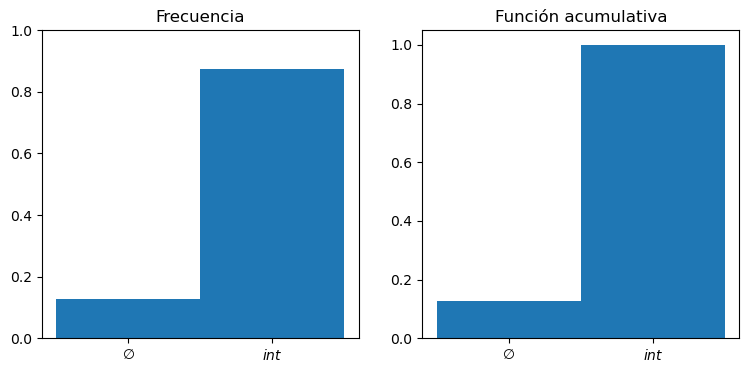

In [30]:
fig,ax=plt.subplots(1,2,figsize=(9,4))
ax[0].bar([r"$\varnothing $",r"$int$"],pdf1,width=1)
ax[0].set_ylim(0,1)
ax[0].set_title("Frecuencia")
ax[1].bar([r"$\varnothing $",r"$int$"],cdf1,width=1)
ax[1].set_title("Función acumulativa")
plt.show()

Fotoeléctrico o Compton

In [31]:
Pf=mu_f/mu #Definimos las probabilidades relativas de que el caso sea interacción fotoeléctrica o Compton
Pc=mu_c/mu
pdf2=np.array([Pf,Pc]) #Creamos la segunda pdf asociada a cuando es interaccion fotoelectrica o de Compton
cdf2=np.cumsum(pdf2)


Graficamos

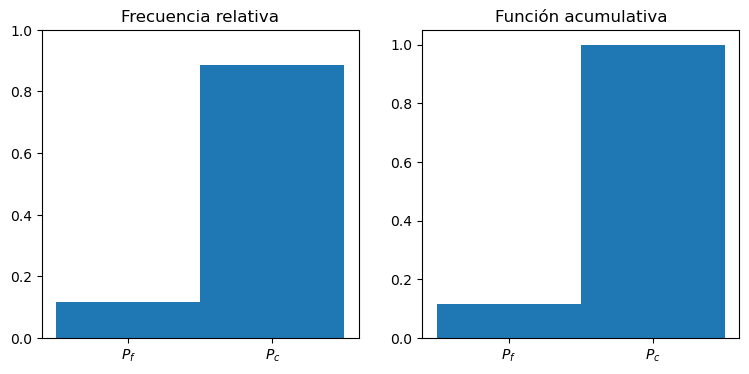

In [32]:
fig,ax=plt.subplots(1,2,figsize=(9,4))
ax[0].bar([r"$P_f $",r"$P_c$"],pdf2,width=1)
ax[0].set_ylim(0,1)
ax[0].set_title("Frecuencia relativa")
ax[1].bar([r"$P_f $",r"$P_c$"],cdf2,width=1)
ax[1].set_title("Función acumulativa")
plt.show()

Análisis Compton

In [33]:
def dist_E_c(E_e):    #Función de distribución de probabilidad de Energías de Compton
    eps_e=E_e/E
    eps_gamma=E/511
    a=(eps_e**2)/(eps_gamma**2*((1-eps_e)**2))
    b=(eps_e)/(1-eps_e)
    c=eps_e-((2)/(eps_gamma))
    d= 2+a+b*c
    return d

Es_c=np.arange(0,E_c,deltaE) #discretización energía para obtener la pdf de compton



pdf_Ec=dist_E_c(Es_c)
cdf_Ec=np.cumsum(pdf_Ec)
cdf_Ec=cdf_Ec/cdf_Ec.max() #Normalización de la cdf


@njit
#Función que por simulación por montecarlo obtiene el valor de la energía de Compton
def Energia_compton():
    r = rn.random()    
    a=r<=cdf_Ec
    return Es_c[a][0]
    






# Simulación

Funciones auxiliares

In [34]:
#Funcion que decide si se da o no una interacción
@njit
def interacción():
    r=rn.random()
    if r>cdf1[0]:
        return True
    else:
        return False

#Funcion si decide si la interacción es por Compton o fotoeléctrico
@njit
def fotoelectrico():
    r=rn.random()
    if r>cdf2[0]:
        return False
    else:
        return True
    


Funcion simulacion


In [35]:
@jit
def simul_sin_FWHM(N_fotones):
    Energias=np.arange(0,800,deltaE) #Creamos los canales con sus energías
    cuentas=np.zeros(len(Energias)) #Creamos las cuentas de los hisstogramas a cada energía
    N_fotones=int(N_fotones)
    for foton in range(0,N_fotones):        
        if interacción(): # Evaluar si hay interacción
            if fotoelectrico(): #Evaluar si hay efecto fotoelectrico
                cuentas[4*E]+=1 #Añadir cuenta al fotopico de 662 keV       
            else:
                cuentas[Energias==Energia_compton()]+=1  #Añadir energía a la cuenta de Fotoeléctrico
        else:
            continue
    
    return Energias,cuentas



/tmp/ipykernel_7702/1757200208.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def simul_sin_FWHM(N_fotones):


In [36]:
x,y=simul_sin_FWHM(1000000)


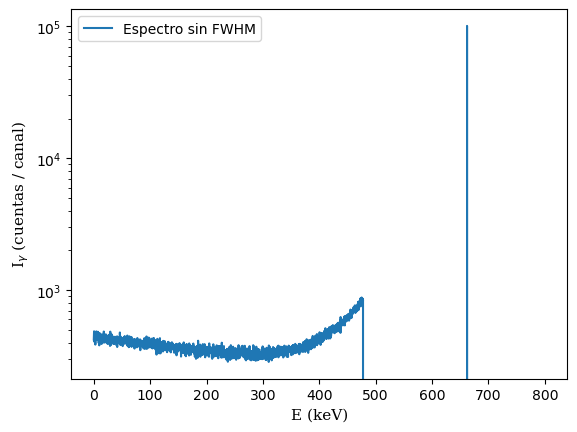

In [37]:
plt.plot(x,y,label="Espectro sin FWHM")
plt.yscale("log")
plt.xlabel("E (keV)", fontsize=11,family="serif")
plt.ylabel("I$_\gamma$ (cuentas / canal)", fontsize=11,family="serif")
plt.legend()

Regiones Compton

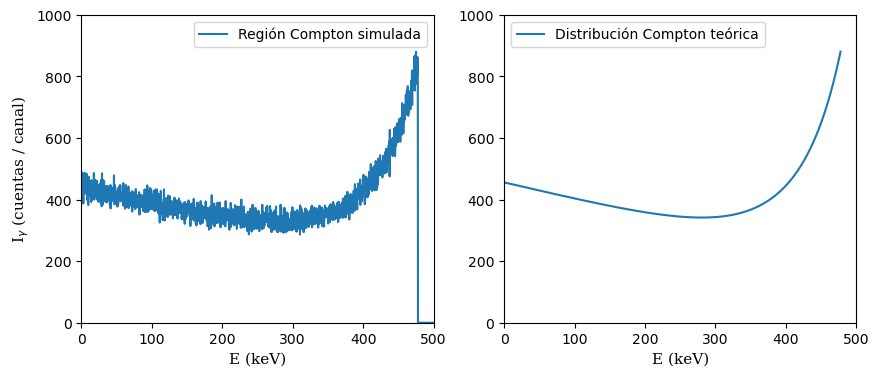

In [38]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].plot(x,y,label="Región Compton simulada")
ax[0].set_ylim(0,1000)
ax[0].set_xlim(0,500)
ax[0].set_xlabel("E (keV)", fontsize=11,family="serif")
ax[0].set_ylabel("I$_\gamma$ (cuentas / canal)", fontsize=11,family="serif")
ax[0].legend()

ax[1].plot(Es_c,pdf_Ec/pdf_Ec.max()*y[0:500*4].max(),label="Distribución Compton teórica") #renormalizando para una mejor comparación
ax[1].set_ylim(0,1000)
ax[1].set_xlim(0,500)
ax[1].set_xlabel("E (keV)", fontsize=11,family="serif")

ax[1].legend(loc=2)



Subrutina montecarlo FWHM

In [39]:
def FWHM(E):
    return 2+1.9*np.sqrt(E) #Valor de FWHM según prácticas anteriores



def añadir_Fwhm(E):
    return np.random.normal(E,FWHM(E)/2.35,1)#generar valor de FWHM para la energía



# Simulacion con FWHM

In [40]:

def simul_con_FWHM(N_fotones):
    Energias=np.arange(0,800,deltaE) #Creamos los canales con sus energías
    cuentas=np.zeros(len(Energias)) #Creamos las cuentas de los hisstogramas a cada energía
    N_fotones=int(N_fotones)
    for foton in range(0,N_fotones):        
        if interacción(): # Evaluar si hay interacción
            if fotoelectrico(): #Evaluar si hay efecto fotoelectrico
                E_f=añadir_Fwhm(E)
                indice=Energias[Energias>=E_f][0]
                cuentas[int(4*indice)]+=1 #Añadir cuenta al fotopico de 662 keV       
            else:         
                indice=Energias[Energias>=añadir_Fwhm(Energia_compton()) ][0]                
                cuentas[int(4*indice)]+=1  #Añadir energía a la cuenta de Fotoeléctrico
                
        else: continue
        
    
    return Energias,cuentas

In [41]:
x,y=simul_con_FWHM(1e6)



In [42]:


Cs137=pd.read_table("./NaI_137Cs_600s.dat",sep="\s+")

Fondo_600s=pd.read_table("./NaI_Fondo_600s.dat",sep="\s+")

Fondo6y=Fondo_600s.cuentas

canal=Fondo_600s.canal
cuentas=Cs137.cuentas-Fondo6y
def E_exp(canal):
    return 3.16*canal-60

def canals(E):
    return (E+60)/3.16

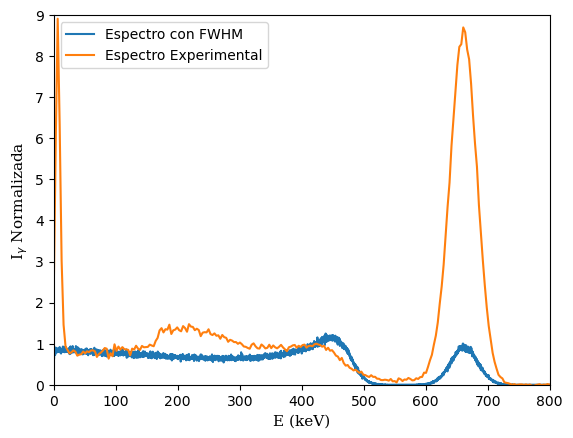

In [47]:
y=y/y[1910:].max()#Normalizar el espectro simulado
plt.plot(x,y,label="Espectro con FWHM")
plt.xlim(0,800)
plt.ylim(0,9)
plt.xlabel("E (keV)", fontsize=11,family="serif")
plt.ylabel("I$_\gamma$ Normalizada", fontsize=11,family="serif")


Energia_exp=E_exp(canal) #Conversión a enrgía del espectro observado
cuentas/=cuentas[150:200].max()

plt.plot(Energia_exp,cuentas,label="Espectro Experimental")
plt.legend()



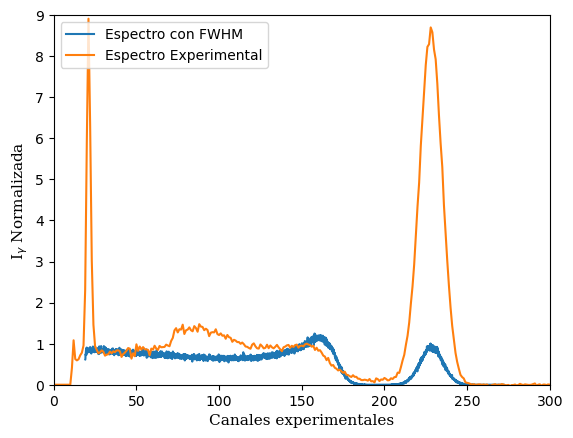

In [49]:

x1=canals(x)
canal=Fondo_600s.canal
cuentas=Cs137.cuentas-Fondo6y
cuentas/=cuentas[150:200].max()
plt.plot(x1[1:],y[1:],label="Espectro con FWHM")
plt.xlim(0,300)
plt.ylim(0,9)
plt.xlabel("Canales experimentales", fontsize=11,family="serif")
plt.ylabel("I$_\gamma$ Normalizada", fontsize=11,family="serif")



#cuentas/=cuentas

plt.plot(canal,cuentas,label="Espectro Experimental")
plt.legend(loc=2)
